#### *Analyze a family of RNNs all trained on the same data but with different hyperparameters.*

Essentially, most RNNs fit the muscle activity data (EMG) with almost the same loss.

(This is a very easy task from an ML standpoint.)

But not all such RNNs are equivalent as RNNs are overparametrized, and their internal behavior depends on hyperparameters. Here we investigate this dependence.

The cost function for the RNN
$$ \sum_{t,c}\|\hat{y}(t,c) - y(t,c)\|_2^2 + \lambda_1\|A\|_F^2 + \lambda_2\|C\|_F^2,$$
where $A$ and $C$ are the state-to-state and state-to-output matrices, respectively.

The RNN hyperparameters,
- $\lambda_1$
- $\lambda_2$
- $\sigma_w$ (std dev of noise injected into neurons during training

are compared against various measures of RNN activation trajectories
- mean curvature
- mean curvature (path length normalized)
- mean torsion (generalized curvature)
- trajectory "tangling" (a "global measure of curvature")
- path length
- dimensionality (participation ratio)
- average of the norms of the Jacobian evaluated at all path points
- "noise robustness"
- "structural robustness"

The latter two measures are obtained by resimulating the RNN and injecting noise to the state variables (noise robustness) or by adding a random perturbation to $A$ (structural robustness) and then finding the strength of noise required to drop the EMG fit to $R^2< 0.5$. This is tricky because a small perturbation in $A$ can result in EMG fits that are *qualitiatively* good but *quantitatively* bad (e.g. small frequency changes might result in a huge drop in $R^2$). Thus we use dynamic time warping (DTW) as a measure of loss instead of $MSE$ or $R^2$---first apply DTW then take $R^2$. This minor details turns out to actually make a difference.

----------

### TODO
Do:
- [DONE] Test for 1 condition only
- Lie stuff -- lie bracket, lie derivatives, etc
- regularize the RNN activations maybe
- [DONE] normalize by path length for curvature calculations
- [DONE] check to make sure dtw is working correctly
- plot ref lines for M1 data


# 0. Initial stuff

In [12]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append('../')

In [14]:
import numpy as np
import scipy.io as sio
import sklearn as sk

from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

# For jupyter tensorboarding
from io import BytesIO
from functools import partial
import PIL.Image
from ipywidgets import FloatProgress

from IPython.display import clear_output, Image, display, HTML

import pickle
import os
import pprint as pp

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [15]:
import cyclingrnn.geometric as geo
from cyclingrnn import sigerr
from cyclingrnn.train import *

In [16]:
# sns colormaps
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

# Geometric analysis functions
Set of functions for analyzing geometric properties of shape `(time, batch_size, dimension)` signals. 

In [17]:
# def tangling(signal_in, alpha=0.1, dt=0.025):
#   '''
#     Computes "tangling," a global-ish measure of curvature of a curve
#     Inputs
#       signal_in: (T, batch_size, n) signal
#       alpha: factor for how much to scale np.var() in the denominator
#       dt: time units
#     Outputs
#       Q: (T, batch_size) tangling metric
#   '''
#   sig_diff = np.diff(signal_in, axis=0)
#   signal_in = signal_in[1:, :, :]
#   Q = np.zeros(signal_in.shape[:2])
#   const = alpha*np.sum(np.var(signal_in, axis=(0,1)))
#   for t in range(signal_in.shape[0]):
#     for b in range(signal_in.shape[1]):
#       num = np.sum((sig_diff[t, b, :]/dt - sig_diff/dt)**2, axis=2)
#       den = np.sum((signal_in[t, b, :] - signal_in)**2, axis=2) + const
#       Q[t, b] = np.max(num/den)
#   return Q

# def percent_tangling(x_in, y_in, th=1, alpha=0.1):
#   """
#     scalar summary of tangling() results
#     percent tangling, i.e. percentage of points above the y=th*x line
#     Inputs
#       x_in: (T, batch_size, n) signal
#       y_in: (T, batch_size, n) reference signal
#       th: threshold or slope
#       alpha: fed into tangling()
#     Outputs
#       percent tangling scalar
#   """
#   q_emg = tangling(y_in, alpha=alpha)
#   q_m1 = tangling(x_in, alpha=alpha)
#   ratio = q_m1/q_emg
#   return np.true_divide(np.sum(ratio > th), ratio.size)

# def mean_tangling(x_in, alpha=0.1):
#   """
#     scalar summary of tangling() results
#     mean tangling, i.e. just the mean
#     Inputs
#       x_in: (T, batch_size, n) signal
#       alpha: fed to tangling()
#   """
#   return np.mean(tangling(x_in, alpha=alpha))

# def dist_tangling(x_in, y_in, alpha=0.1):
#   """
#     scalar summary of tangling() results
#     sum of signed squared distances of [x_in, y_in] from diagonal
#     todo: sum of signed squared distances?
#   """
#   q_y = tangling(y_in, alpha=alpha)
#   q_x = tangling(x_in, alpha=alpha)
#   q = np.array((q_y.flatten(), q_x.flatten()))
#   ones = np.ones_like(q)
#   sign = (q[0,:] > q[1,:]).astype('int')
#   sign[sign==0] = -1 # above or below diagonal?
#   # next line just implements distance calculation. maybe not efficient.
#   return np.sum(sign*np.linalg.norm(np.diag(np.dot(q.T, ones))/2.*ones - q, axis=0)**2)
  
# def mean_curvature_osculating(signal_in, filt_freq=None):
#   """
#     mean curvature based on get_curvature() function, which fits an osculating circle to three consecutive points
#     used mostly for sanity checking: making sure the actual mean_curvature() function is giving correct results
#     which it is. so, time to remove this. 
#   """
#   if filt_freq is not None:
#     from scipy import signal
#     b, a = signal.butter(4, filt_freq)
#     signal_in = signal.filtfilt(b, a, signal_in, axis=0)

#   C = signal_in.shape[1]
#   k = np.zeros(signal_in.shape[:-1])
#   for c in range(C):
#     k[:, c] = get_curvature_osc(signal_in[:, c, :])
#   k[k==0] = np.nan
#   return np.nanmean(k, axis=(0,1))
  
# def normalize_path(signal_in, filt_freq=0.3):
#   """
#     normalizes path to length 1
#     normalizes across all conditions/batches (TODO: change this?)
#   """
#   return signal_in/np.sum(get_path_length(signal_in, filt_freq=filt_freq))
  
# def mean_curvature(signal_in, total_points=11, deg=4, normalize=False):
#   """
#     mean curvature based on get_generalized_curvature() function
#   """
#   if normalize:
#     signal_in = normalize_path(signal_in)
#   C = signal_in.shape[1]
#   k = np.zeros(signal_in.shape[:-1]+(deg-1,))
#   for c in range(C):
#     k[:, c, :], _ = get_generalized_curvature(signal_in[:, c, :], total_points, deg)
#   k[k==0] = np.nan
#   return np.nanmean(k, axis=(0,1))

# def get_participation_ratio(signal_in):
#   """
#     Participation ratio is an approximate measure of dimensionality.
#     PR = sum(evs)**2/sum(evs**2)
#     where evs are the eigenvalues of the covariance matrix of signal_in
#     signal_in is shape (T, batch_size, n), which is reshaped to (T*batch_size, n)
#     the covariance matrix is size (n, n)
#   """
#   signal_in = np.reshape(signal_in, [-1, signal_in.shape[-1]], order='F')
#   Cov = np.cov(signal_in.T)
#   eigvals = np.linalg.eigvals(Cov)
#   return np.sum(eigvals)**2/np.sum(eigvals**2)

# def tanh(x):
#   return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
# def dtanh(x):
#   ''' derivative of tanh() '''
#   return 1. - tanh(x)**2

# def get_jacobian(sim):
#   """
#     get the jacobian matrix of the RNN
#     output: J, a function that takes x, u as vector inputs and returns the jacobian evaluated at those points
#   """
#   # get A, B
#   TF_PATH = RUN+'tfsaves/'+str(sim)
#   tf.reset_default_graph()
#   with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
#     new_saver.restore(sess, TF_PATH)
#     # Get Mat variable
#     Mat = sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCell/Linear/Matrix:0'][0])
#     A = Mat[2:]
#     B = Mat[:2]
#   def J(x, u):
#     return np.dot(A, np.diag(dtanh(np.dot(A.T, x) + np.dot(B.T, u))))
#   return J

# def get_sum_of_jacobians(sim, x_in, u_in, norm='fro', squared=True):
#   """
#     get the jacobian and evaluate it at every point in x_in (T, batch_size, n).
#     take the norm of the jacobian using `norm` (use 'trace' to caculate divergence)
#     average across T and batch_size.
#   """
#   J = get_jacobian(sim)
#   R = 0
#   for t in range(x_in.shape[0]):
#     for c in range(x_in.shape[1]):
#       J_ = J(x_in[t, c, :], u_in[t, c, :])
#       if norm == 'trace':
#         R_ = np.trace(J_)
#       else:
#         R_ = np.linalg.norm(J_, norm)
#       if squared:
#         R_ = R_**2 
#       R += R_
#   R = np.true_divide(R, np.prod(x_in.shape[:2]))
#   return R



# Signal error functions
Functions that return the error between signals `x` and `y` of shapes `(time, batch_size, dimension)`.

In [18]:
# # signal errors
# def r2_sigerr(x, y):
#   """ R_squared of two signals"""
#   err = metrics.r2_score(np.reshape(y, [-1, y.shape[-1]]),
#                          np.reshape(x, [-1, x.shape[-1]]), multioutput='uniform_average')
#   return err

# def mse_sigerr(x, y):
#   """ MSE of two signals """
#   return np.mean((x - y)**2)

# # Rpy2 stuff
# import rpy2.robjects.numpy2ri
# from rpy2.robjects.packages import importr
# rpy2.robjects.numpy2ri.activate()
# # Set up our R namespaces
# R = rpy2.robjects.r
# DTW = importr('dtw')
# def dtw_sigerr_R(x, y):
#   """ dynamic time warping error (R package) """
#   dist = []
#   idx1 = []
#   idx2 = []
#   for c in range(x.shape[1]):
#     alignment = R.dtw(np.squeeze(x[:, c, :]), np.squeeze(y[:, c, :]), keep=False, window='none', step=DTW.asymmetric)
#     dist.append(alignment.rx('distance')[0][0])
#     idx1.append(np.array(alignment.rx('index1')[0]).astype('int')-1)
#     idx2.append(np.array(alignment.rx('index2')[0]).astype('int')-1)
#   #Now get R2
#   x_ = []
#   y_ = []
#   for c in range(x.shape[1]):
#     x_.append(x[path[c][0], c, :])
#     y_.append(y[path[c][1], c, :])
#   x_ = np.concatenate(x_)
#   y_ = np.concatenate(y_)
#   err = r2_sigerr(x_, y_)
#   return np.mean(dist), err

# def dtw_sigerr_P(x, y):
#   """ dynamic time warping error (python package) """
#   def mydist(x, y):
#     return np.linalg.norm(x-y, ord=np.inf)
#   dist = []
#   path = []
#   for c in range(x.shape[1]):
#     dist_, cost, acc, path_ = dtw(np.squeeze(x[:,c,:]), np.squeeze(y[:,c,:]), dist=mydist)
#     dist.append(dist_)
#     path.append(path_)
  
#   x_ = []
#   y_ = []
#   for c in range(x.shape[1]):
#     x_.append(x[path[c][0], c, :])
#     y_.append(y[path[c][1], c, :])
#   x_ = np.concatenate(x_)
#   y_ = np.concatenate(y_)
#   err = r2_sigerr(x_, y_)
#   return np.mean(dist), err


# Simulation-related functions

In [19]:
def get_full_data(cur_params):
  """
    returns u_data, y_data for tensorflow's feed_dict.
  """
  path_prefix = '/Users/jeff/Documents/Python/_projects/cyclingRNN/'
  if cur_params['monkey']=='D':
    data = sio.loadmat(path_prefix+'drakeFeb.mat')
  else:
    data = sio.loadmat(path_prefix+'cousFeb.mat')

  # Built augmented data
  emg2 = preprocess_array(data['D'][0, 0]['EMG'])
  time_axis, time_inds1, time_inds2 = get_time_axis(data['D'][0, 0]['KIN'])
  y_data1 = emg2[time_axis]
  p = y_data1.shape[-1]

  # Build inputs
  m = 2
  u_data1 = create_input_array(y_data1.shape)

  # Augmented data
  # For regularizing the network -- it must fit actual and augmented data
  period = int(np.round(np.diff(time_inds2).mean()))
  y_cat1 = augmented_data(emg2, time_inds1, period=period, tiles=10)
  y_cat1 = y_cat1[::25]
  y_cat2 = augmented_data(emg2, time_inds2, period=period, tiles=10)
  y_cat2 = y_cat2[::25]

  u_cat1 = create_input_array(y_cat1.shape)
  u_cat2 = create_input_array(y_cat2.shape)

  sequence_length = [y_data1.shape[0], y_cat1.shape[0], y_cat2.shape[0]]
  y_data = np.zeros((np.max(sequence_length), 4*3, p))
  u_data = np.zeros((np.max(sequence_length), 4*3, m))

  y_data[:sequence_length[0], 0:4, :] = y_data1
  y_data[:sequence_length[1], 4:8, :] = y_cat1
  y_data[:sequence_length[2], 8:12, :] = y_cat2

  u_data[:sequence_length[0], 0:4, :] = u_data1
  u_data[:sequence_length[1], 4:8, :] = u_cat1
  u_data[:sequence_length[2], 8:12, :] = u_cat2
  return u_data, y_data

def mean_squared_error(x, y):
  return np.mean((x - y)**2)

def get_noise_sim(stddev_struct, stddev_state, RUN, sim, y_data, u_data):
  """
    loads TF model. Then simulates it again, but with noise
    stddev_struct: std dev of structural perturbation on weight matrix
    stddev_state: std dev of additive noise to each neuron
    RUN: directory of the current run
    sim: integer for the simulation
    y_data, u_data: reference data for feed_dict
  """
  TF_PATH = RUN+'tfsaves/'+str(sim)
  tf.reset_default_graph()
  with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    # Get Mat variable
    Mat = sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0])
    A = Mat[2:]
    B = Mat[:2]
    newMat = np.zeros(Mat.shape)
    newMat[:2] = B
    newMat[2:] = A + stddev_struct*np.random.randn(A.shape[0], A.shape[1])
    sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0].assign(newMat))
    feed_dict = {'Y:0': y_data, 'U:0': u_data, 'stddev_state:0': stddev_state}
    y_hat, x_hat, loss = sess.run(['Y_hat:0', 'RNN/TensorArrayPack_1/TensorArrayGatherV2:0', 'cost1:0'], feed_dict)
  return y_hat, x_hat, loss

def get_noise_robustness(sim, y_data, u_data, conds, emg, err_f=sigerr.mse_sigerr, dtw_err=False, num=10, trials=4):
  """
    gradually increases noise until error (R squared) drops below 0.5
    tests for both state noise robustness as well as structural robustness
    - state noise robustness: noise of strength sdtdev_state injected into neurons during simulation
    - structural robustness: apply a single noisy perturbation to the matrix A then simulate
    sim: int. which simulation to use.
    y_data, u_data: reference data for feed_dict
    num: input for np.logspace(), number of stddevs...
    
  """
  
  TF_PATH = RUN+'tfsaves/'+str(sim)
  tf.reset_default_graph()
  with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    # Get Mat variable
    Mat = sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0])
    A = Mat[2:]
    B = Mat[:2]

    errors_state = np.zeros((num, trials))
    errors_struct = np.zeros((num, trials))
    
    stddev_struct = 0.
    stddev_state = 0.
    for i_state, stddev_state in enumerate(tqdm(np.logspace(-1.1, 2, num=num), desc='std dev state', leave=False)):
      for tr in range(trials):
        newMat = np.zeros(Mat.shape)
        newMat[:2] = B
        newMat[2:] = A + stddev_struct*np.random.randn(A.shape[0], A.shape[1])
        sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0].assign(newMat))
        feed_dict = {'Y:0': y_data, 'U:0': u_data, 'stddev_state:0': stddev_state}
        y_hat = sess.run('Y_hat:0', feed_dict)
        if dtw_err:
          dist, err = err_f(y_hat[:emg.shape[0], conds, :], emg[:, conds, :])
        else:
          err = err_f(y_hat[:emg.shape[0], conds, :], emg[:, conds, :])
        errors_state[i_state, tr] = err
      if np.mean(errors_state[i_state, :]) < 0.5:
        break

    stddev_state_out = stddev_state
    stddev_struct = 0.
    stddev_state = 0.
    for i_struct, stddev_struct in enumerate(tqdm(np.logspace(-2.1, 1, num=num), desc='std dev struct', leave=False)):
      for tr in range(trials):
        newMat = np.zeros(Mat.shape)
        newMat[:2] = B
        newMat[2:] = A + stddev_struct*np.random.randn(A.shape[0], A.shape[1])
        sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0].assign(newMat))
        feed_dict = {'Y:0': y_data, 'U:0': u_data, 'stddev_state:0': stddev_state}
        y_hat = sess.run('Y_hat:0', feed_dict)
        if dtw_err:
          dist, err = err_f(y_hat[:emg.shape[0], conds, :], emg[:, conds, :])
        else:
          err = err_f(y_hat[:emg.shape[0], conds, :], emg[:, conds, :])
        errors_struct[i_struct, tr] = err
      if np.mean(errors_struct[i_struct, :]) < 0.5:
        break
  
  return stddev_state_out, stddev_struct

# Main run evaluation functions
Functions for evaluating a set of simulations (a `RUN`) of different hyperparameters. Go through the folder associated with the `RUN` and do analyses, which are saved to a pandas dataframe.

In [20]:
def evaluate_run(conds, RUN):
  """
    Evaluate a RUN (all simulations) for a specified choice of conditions (conds)
  """
  # Number of sims in RUN
  total_sims = len([i for i in os.listdir(RUN+'mlsaves') if i!='.DS_Store'])
  # Get monkey
  cur_params = pickle.load(open(RUN+'npsaves/'+str(1)+'params.pickle', 'rb'))
  # build input and output data
  if cur_params['monkey']=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
  else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')
  emg = data['EMG']
  m1 = data['M1']
  u_full, emg_full = get_full_data(cur_params)

  params = []
  out_metrics = []
  f = FloatProgress(min=1, max=(total_sims+1), description='Run: '+RUN+'. Condition: '+str(conds))
  display(f)
  for sim in range(1,total_sims+1):
    f.value += 1
    cur_params = pickle.load(open(RUN+'npsaves/'+str(sim)+'params.pickle', 'rb'))
    x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
    y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
    # truncate to remove augmented data
    x_trunc = x[:emg.shape[0], :emg.shape[1], :]
    y_trunc = y[:emg.shape[0], :emg.shape[1], :]
    u_trunc = create_input_array(y_trunc.shape)

    # truncate conditions
    x_trunc = x_trunc[:, conds, :]
    y_trunc = y_trunc[:, conds, :]
    u_trunc = u_trunc[:, conds, :]

    emg_ = emg[:, conds, :]

    # get params
    params.append(cur_params)

    mets = dict()
    # Tangling
    mets['percent_tangling'] = geo.percent_tangling(x_trunc,emg_) # note condition truncation on emg
    mets['percent_tangling2'] = geo.percent_tangling(x_trunc,emg_,th=2) # note condition truncation on emg
    mets['percent_tangling4'] = geo.percent_tangling(x_trunc,emg_,th=4) # note condition truncation on emg
    mets['mean_tangling'] = geo.mean_tangling(x_trunc, alpha=0.01)
    mets['distance_tangling'] = geo.dist_tangling(x_trunc, emg_, alpha=0.01)
    
    mets['path_length'] = np.sum(geo.get_path_length(x_trunc, filt_freq=0.25))
    mets['mean_curvature_osc'] = geo.mean_curvature_osculating(x_trunc, filt_freq=0.25)
    mets['mean_curvature'] = geo.mean_curvature(x_trunc, total_points=11, deg=4, normalize=True)
    
    mets['jacobians'] = geo.get_sum_of_jacobians(sim, RUN, x_trunc, u_trunc, 'fro')
    
    mets['PR'] = geo.get_participation_ratio(x_trunc)
    mets['MSE'] = metrics.mean_squared_error(np.reshape(emg_, [-1,emg_.shape[-1]]),
                                              np.reshape(y_trunc, [-1, y_trunc.shape[-1]]), multioutput='uniform_average') # condition truncation on emg
    mets['R2'] = metrics.r2_score(np.reshape(emg_, [-1, emg_.shape[-1]]),
                                  np.reshape(y_trunc, [-1, y_trunc.shape[-1]]), multioutput='uniform_average') # condition truncation on emg
    
    err_fun = sigerr.dtw_sigerr_P
    mets['noise_robustness'], mets['struct_robustness'] = get_noise_robustness(sim, emg_full, u_full,
                                                                               conds, emg, err_fun, dtw_err=True, num=80, trials=4)
    out_metrics.append(mets)
    
  return params, out_metrics

In [21]:
def process_dataframe(params, out_metrics):
  """
    panda panda panda
  """
  # join params and metrics into one dataframe
  df = pd.DataFrame(params)
  metrics_df = pd.DataFrame(out_metrics)
  df = df.join(metrics_df)
  
  # remove bad fits
  inds = df['R2'] > 0.5
  df = df[inds]
  
  #Split the generalized curvature columns into multiple columns, one for each curvature
  mc = df['mean_curvature'].apply(pd.Series)
  mc.rename(columns={0: 'mean_curvature'}, inplace=True)
  mc.rename(columns={1: 'mean_torsion'}, inplace=True)
  mc = mc[['mean_curvature', 'mean_torsion']]
  df = df.drop('mean_curvature', 1)
  df = df.join(mc)
  
  return df

# Run hyperparameter analysis 
Now loop through a set of `RUN`s, create and save the summary dataframes. Takes a long time. Grab a ☕

Additional option to loop through a set of conditions (batches), necessary for seeing if there is any discernable difference in results when analyzing just forward `[0,1]`, just backward `[2,3]`, or forward + backward `[0,1,2,3]`.

In [ ]:
RUNset = ['../saves/170208D/', '../saves/170208C/']
condset = [[0,1], [0,1,2,3]]

for RUN in RUNset:
  for conds in condset:
    params, out_metrics = evaluate_run(conds, RUN)
    df = process_dataframe(params, out_metrics)
    pickle.dump(df, open(RUN+'df'+''.join(map(str,conds))+'.pickle', 'wb'))

../cyclingrnn/geometric.py:213: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.linalg.norm(a)**2*np.linalg.norm(b)**2 - np.dot(a, b)**2)
../cyclingrnn/geometric.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  r = np.linalg.norm(A)*np.linalg.norm(B)*np.linalg.norm(A-B)/(2*cross_id2(A, B))
std dev state:   5%|▌         | 4/80 [00:05<01:52,  1.47s/it]

# Visualize results

In [ ]:
df_path = '../saves/1-12-D/df0123.pickle'
df = pickle.load(open(df_path))

In [ ]:
# Display columns
df.columns

In [ ]:
cols = [u'beta1', u'beta2', u'stddev_state'] # hyperparameters of the model
exclude = [u'monkey', u'num_neurons', u'activation', u'stddev_out'] # exclude these
rows = list(set(df.columns) - set(cols) - set(exclude)) # everything else
logx = [u'beta1', u'beta2', u'stddev_state'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 4
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

In [ ]:
f, ax = plt.subplots(1,1,figsize=(4,4))
sns.regplot('mean_tangling', 'struct_robustness', df, ax=ax)

In [ ]:
f, ax = plt.subplots(2,2, figsize=(10,10))
f.suptitle('Monkey '+df.monkey.iloc[0])
sns.regplot('mean_tangling', 'noise_robustness', df, ax=ax[0,0])
sns.regplot('mean_tangling', 'struct_robustness', df, ax=ax[0,1])
sns.regplot('distance_tangling', 'noise_robustness', df, ax=ax[1,0])
sns.regplot('distance_tangling', 'struct_robustness', df, ax=ax[1,1])

# doodle doodle

In [22]:
cur_params = {}
cur_params['monkey'] = 'D'

In [33]:
u_data, y_data = get_full_data(cur_params)
if cur_params['monkey']=='D':
  data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
else:
  data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')
emg = data['EMG']
m1 = data['M1']

In [44]:
q_m1 = geo.tangling(m1)
q_emg = geo.tangling(emg)

In [ ]:
plt.plot

In [78]:
th = 5
geo.percent_tangling(m1, emg, th=th)

1.0

0.905063291139


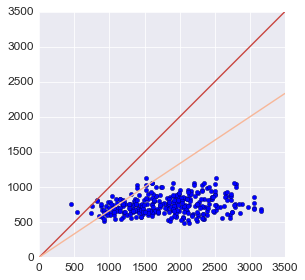

In [103]:
th = 1.5
percent = geo.percent_tangling(m1, emg, th=th)
print percent
plt.scatter(q_emg, q_m1)
plt.plot([0, 3500], [0, 3500])
plt.plot([0, 3500], [0, 1./th*3500.])
plt.axis('square')
plt.xlim([0, 3500])
plt.ylim([0, 3500])
plt.show()

In [192]:
x = np.copy(m1[:,:,np.random.randint(0, 100, size=20)])
y = np.copy(emg[:,:,np.random.randint(0, 36, size=20)])

import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
# Set up our R namespaces
R = rpy2.robjects.r
DTW = importr('dtw')

dist = []
idx1 = []
idx2 = []
for c in range(x.shape[1]):
  alignment = R.dtw(np.squeeze(x[:, c, :]), np.squeeze(y[:, c, :]), keep=False, window='none', step=DTW.asymmetric)
  dist.append(alignment.rx('distance')[0][0])
  idx1.append(np.array(alignment.rx('index1')[0]).astype('int')-1)
  idx2.append(np.array(alignment.rx('index2')[0]).astype('int')-1)
#Now get R2
x_ = []
y_ = []
for c in range(x.shape[1]):
  x_.append(x[path[c][0][5:-5], c, :])
  y_.append(y[path[c][1][5:-5], c, :])
x_ = np.concatenate(x_)
y_ = np.concatenate(y_)
err = sigerr.r2_sigerr(x_, y_)

In [232]:
np.squeeze(x[:,c,:]).shape

(80, 5)

In [249]:
def mydist(x, y):
  return np.linalg.norm(x-y)

In [244]:
mydist(np.squeeze(x[:,c,:]), np.squeeze(y[:,c,:]))

0.50032866375917817

In [246]:
len(np.squeeze(x[:,c,:]))

80

In [250]:
x = np.copy(m1[:,:,np.random.randint(0, 50, size=5)])
y = np.copy(emg[:,:,np.random.randint(0, 36, size=5)])
dist = []
path = []
for c in range(x.shape[1]):
  dist_, cost, acc, path_ = dtw(np.squeeze(x[:,c,:]), np.squeeze(y[:,c,:]), dist=mydist)
  dist.append(dist_)
  path.append(path_)


In [ ]:
dtw()

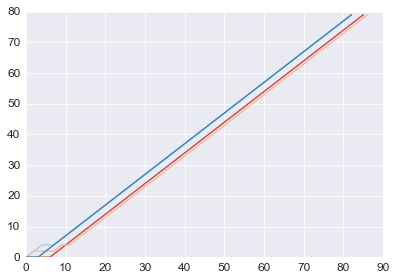

In [251]:
for c in range(x.shape[1]):
  plt.plot(path[c][0])
plt.show()

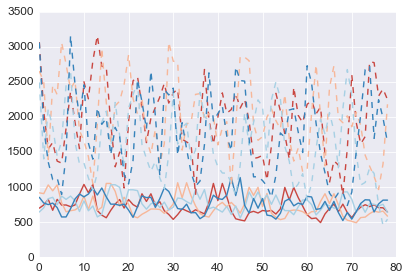

In [46]:
plt.plot(q_m1)
plt.plot(q_emg,'--')